<h1>LECTURE DE CARTE CNI<h1>
<h3> Il arrive parfois ,et même souvent que vous perdiez votre clé ubs contenant tous vos fichiers PDF. Heuresement que vous avez la version papier des PDF.<h3>
<h2> Flemme de tous retaper, voici la solution appliquée à une carte d identité Française<h2>

In [1]:
#Configuration
!pip install opencv-python
!pip install pillow
!pip install tesseract
!pip install pytesseract==0.3.6
!pip install scipy
!pip install imutils

In [231]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import imutils
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops

### Objectif du projet

In [232]:
def read(img_path):
    
    print ('--- Start recognize text from image ---')
    
    #stringToMatch = '(NI)'

    result1 = pytesseract.image_to_string(Image.open(img_path))
    #print (result1)
    #print("=============================================")

    #idx_string = result1.find(stringToMatch)
    #result2 = filter(lambda x : x.isdigit(), result1[idx_string:])
    return result1

In [233]:
CNI = read("extract.jpg")
print(CNI)

--- Start recognize text from image ---
REPUBLIQUE FRANCAISE

CARTE NATIONALE D'IDENTITE N°: 012345678987 Nationalité Francaise
PA Nom: DURAND

Prénom(s): ANTOINE, PAUL, HENRI

Sexe : M Néle) le: 01.01.1960
a: PARIS ( 75 )

Taille: 1,80m
Signature —
du titulaire :

IDFRADURAND<<<<<<<<<<<<<<<<<<<<75000
01234567898 7ANTOINE<<PAUL<<1234567A1



# Démarche

#### Prendre une photo de la carte d'identité en entier, et recouvre au moins 70% de l'image

# Pivoter et extraire la Carte

In [309]:
#saisir l'image
fichier='cni.jpg'
img = cv2.imread(fichier)
HauteurImage=img.shape[0]
LongueurImage= img.shape[1]
cv2.imshow("image",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [310]:
#filtration moins brutale
def preProcessing1(img,LongueurImage,HauteurImage,iteration):
    imgCopie=cv2.resize(img,(LongueurImage,HauteurImage))
    gray = cv2.cvtColor(imgCopie, cv2.COLOR_BGR2RGB)
    blured = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
    imgCanny= cv2.Canny(blured, 30,15)
    kernel = np.ones((5,5))
    imgDial = cv2.dilate(imgCanny,kernel,iterations=iteration)
    imgThres = cv2.erode(imgDial,kernel,iterations=1)
    return imgThres

In [311]:
#filtration plus brutale
def preProcessing2(img,LongueurImage,HauteurImage,iteration):
    imgCopie=cv2.resize(img,(LongueurImage,HauteurImage))
    gray = cv2.cvtColor(imgCopie, cv2.COLOR_BGR2RGB)
    blured = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
    imgCanny= cv2.Canny(blured, 80,100)
    kernel = np.ones((5,5))
    imgDial = cv2.dilate(imgCanny,kernel,iterations=iteration)
    imgThres = cv2.erode(imgDial,kernel,iterations=1)
    return imgThres

In [312]:
# convertir la forme en un rectangle
def shape4(biggest):
    biggest=biggest
    L1=[]
    L2=[]
    if biggest.shape != (4,1,2):
        for i in biggest:
            L1.append(i[0][0])
            L2.append(i[0][1])
        biggest=np.array([[[min(L1),min(L2)]],[[min(L1),max(L2)]],[[max(L1),min(L2)]],[[max(L1),max(L2)]]],np.int32)
    return biggest

In [313]:
# prendre le contour de la carte
def getContours(imgThres):
    biggest=np.array([])
    maxArea = 0
    contours,hierarchy = cv2.findContours(imgThres,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area>500:
            cv2.drawContours(imgThres,cnt,-1,(120,120,120),3)
            peri = cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            if area > maxArea and len(approx) in (4,5,6,7,8,9,10):
                biggest = approx
                maxArea = area
    biggest=shape4(biggest)
    return biggest

In [314]:
#Choisir entre preProcessing 1 ou 2
iteration = 3 # augmenter le nombre d'itération pour avoir moins de détaille sur l'image
imgThres=preProcessing1(img,LongueurImage,HauteurImage,iteration)
getContours(imgThres)
cv2.imshow("Image",imgThres)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Quand le contour est assez bien définit, on gardera ces paramètres 

In [315]:
# réordoner les points du rectangle
def reorder(myPoints):
    myPoints = myPoints.reshape((4,2))
    myPointNew=np.zeros((4,1,2),np.int32)
    add=myPoints.sum(1)
    myPointNew[0]= myPoints[np.argmin(add)]
    myPointNew[3]= myPoints[np.argmax(add)]
    diff=np.diff(myPoints,axis=1)
    myPointNew[1]= myPoints[np.argmin(diff)]
    myPointNew[2]= myPoints[np.argmax(diff)]
    return myPointNew

In [316]:
#prendre les lignes et colonnes
def resize(biggest):
    L=[]
    H=[]
    for i in biggest:
        L.append(i[0][0])
        H.append(i[0][1])
    return L,H


In [317]:
#prendre la hauteur max
def disV(biggest):
    L,H = resize(biggest)
    Vt1= np.sqrt((L[0]-L[2])**2+(H[0]-H[2])**2)
    Vt2= np.sqrt((L[1]-L[3])**2+(H[1]-H[3])**2)
    return int(max(Vt1,Vt2)+1)

In [318]:
#prendre la longueur max
def disH(biggest):
    L,H = resize(biggest)
    ht1= np.sqrt((L[0]-L[1])**2+(H[0]-H[1])**2)
    ht2= np.sqrt((L[2]-L[3])**2+(H[2]-H[3])**2)
    return int(max(ht1,ht2)+1)

In [319]:
#rogner les contours et extraire l'image avec ses propres dimensions
def Crop(img,biggest,LongueurImage,HauteurImage):
    imgCopie=cv2.resize(img,(LongueurImage,HauteurImage))
    biggest = reorder(biggest)
    H=disH(biggest)
    V=disV(biggest)
    pts1=np.float32(biggest)
    pts2=np.float32([[0,0],[H,0],[0,V],[H,V]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgOutput = cv2.warpPerspective(imgCopie,matrix,(H,V))
    return imgOutput

In [320]:
biggest=getContours(imgThres)
imgCrop=Crop(img,biggest,LongueurImage,HauteurImage)
cv2.imshow("Image",img)
cv2.imshow("I",imgCrop)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [321]:
#Si nécessaire, pivoter l'image
angle=0
Rotate = imutils.rotate(imgCrop,angle)
cv2.imshow("Rotate",Rotate)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [322]:
# L'extraction marche donc, on l'enregistre
cv2.imwrite('Recto.jpg', Rotate)
#cv2.imwrite('Verso.jpg', Rotate)

True

# Traitement Image

In [323]:
Traitement='Recto.jpg'
#Traitement='Verso.jpg'
Traite = cv2.imread(Traitement)
cv2.imshow("image",Traite)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [324]:
# Niveaux de gris
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Réduction de bruits
def remove_noise(image):
    return cv2.medianBlur(image,1)
# Seuillage
def thresholding(image,params):
    return cv2.threshold(image, params, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


In [325]:
# modifier le parametre de seuillage
params=100
Otsu =remove_noise(thresholding(grayscale(Traite),params))

In [326]:
cv2.imshow("Otsu",Otsu)
cv2.imshow("Traite",Traite)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [327]:
# Sauvegarde
cv2.imwrite('Otsu_Recto.jpg', Otsu)
#cv2.imwrite('Otsu_Verso.jpg', Otsu)

True

# Lecture Image

In [328]:
CNI_Traite = read(Traitement)
print(CNI_Traite)

--- Start recognize text from image ---
REPUBLIQUE FRANCAISE

CARTE NATIONALE D'IDENTITE N°: 012345678987 Nationalité Francaise
PA Nom: DURAND

Prénom(s): ANTOINE, PAUL, HENRI

Sexe : M Néle) le: 01.01.1960
a: PARIS ( 75 )

Taille: 1,80m
Signature —
du titulaire :

IDFRADURAND<<<<<<<<<<<<<<<<<<<<75000
01234567898 7ANTOINE<<PAUL<<1234567A1



In [329]:
CNI_Otsu = read('Otsu_Recto.jpg')
#CNI_Otsu = read('Otsu_Verso.jpg')
print(CNI_Otsu)

--- Start recognize text from image ---
REPUBLIQUE FRANCAISE

CARTE NATIONALE D'IDENTITE N°: 012345678987 Nationalité Francaise
Pk Nom; DURAND

Prénom(s): ANTOINE, PAOL, HENRI

Sexe: M Néfe)le: 01.01.1960
4: PARIS { 75 )

Tailte: 1, 80m.
Signature —
du titulaire :

IDFRADURAND<<<<<<<<<xeceeex<e<<<75000
01234567898 7ANTOINE<<PAUL<<1234567A1



In [330]:
CNI_Otsu == CNI_Traite # comparaison simple

False

# Extraction du visage

In [331]:
import cv2
import sys

imagePath = sys.argv[1]

# mettre ici Recto.jpg
image = cv2.imread("nettetest.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

print("[INFO] Found {0} Faces.".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    Visage = image[y:y + h, x:x + w]
    cv2.imshow("face",Visage)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
cv2.imwrite('face.jpg', Visage)

[INFO] Found 1 Faces.


True

# Extraction de la signature (recto/verso)

In [332]:
def extract_signature(source_image):

    # read the input image
    img = cv2.imread(source_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
    
    # crop
    HauteurImage=img.shape[0]
    LongueurImage= img.shape[1]
    H1=int(HauteurImage*0.35)
    H2=int(HauteurImage*0.85)
    L1=int(LongueurImage*0.30)
    L2=int(LongueurImage)
    
    # reduction
    Signature = img[H1:H2, L1:L2]
    return Signature

In [333]:
S=extract_signature("Recto.jpg")
#S=extract_signature("Verso.jpg")
cv2.imshow("Signature", S)
cv2.waitKey(0)
cv2.destroyAllWindows()

<a>https://github.com/ahmetozlu/signature_extractor<a>
<p>Ce github montre une méthode d'extraction de signature mais je n'arrive pas à l'utiliser<p>

In [334]:
# read the input image
Sign = cv2.threshold(S, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary

C:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  after removing the cwd from sys.path.


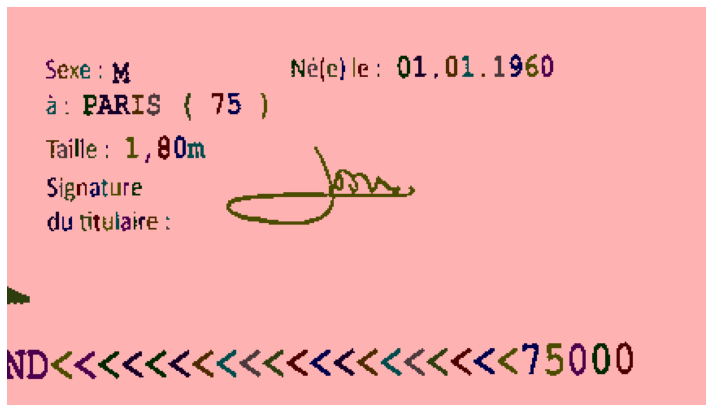

In [335]:
# connected component analysis by scikit-learn framework
blobs = Sign > Sign.mean()
blobs_labels = measure.label(blobs, background=1)
image_label_overlay = label2rgb(blobs_labels, image=Sign)
fig, ax = plt.subplots(figsize=(10, 6))

# plot the connected components (for debugging)
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [336]:
the_biggest_component = 0
total_area = 0
counter = 0
average = 0.0
for region in regionprops(blobs_labels):
    if (region.area > 10):
        total_area = total_area + region.area
        counter = counter + 1
    # print region.area # (for debugging)
    # take regions with large enough areas
    if (region.area >= 250):
        if (region.area > the_biggest_component):
            the_biggest_component = region.area

average = (total_area/counter)
print("the_biggest_component: " + str(the_biggest_component))
print("average: " + str(average))

# experimental-based ratio calculation, modify it for your cases a4_constant is used as a threshold value to remove connected pixels are smaller than a4_constant for A4 size scanned documents
a4_constant = ((average/84.0)*250.0)+100
print("a4_constant: " + str(a4_constant))

# remove the connected pixels are smaller than a4_constant
b = morphology.remove_small_objects(blobs_labels, a4_constant)

# save the the pre-version which is the image is labelled with colors as considering connected components
plt.imsave('pre_version.png', b)

# read the pre-version
Sign = cv2.imread('pre_version.png', 0)

# ensure binary
img = cv2.threshold(Sign, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# save the the result
cv2.imwrite("Signature_Recto.png", Sign)
#cv2.imwrite("Signature_Verso.png", Sign)

the_biggest_component: 745
average: 59.70238095238095
a4_constant: 277.68565759637187


True

In [337]:
E=extract_signature("Signature_Recto.png")
#E=extract_signature("Signature_Verso.png")
cv2.imshow("Signature", E)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Conclusion

#### Contrairement à tous, la lecture d'image marche mieux dans le cas où l'image n'est pas traitée !  la méthode d'otsu permet de réduire l'image à une image binaire. C'est bien pour enlever les bruits, mais il enleve aussi les détailles ! Ainsi, Ce Notebook permet de traiter des CNI de façon correct, à la fois recto et verso.